In [1]:
!pip install transformers
!pip install emoji
!pip install arabic-reshaper
!pip install python-bidi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.1/7.1 MB 73.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 29.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 108.8 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 355.8/355.8 kB 18.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for emoji: filename=emoji-2.5.0-py2.py3-none-any.whl size=351211 sha256=c4baab0c0e3d1df4073bf33f09a807dbb11b6c87770fd47c1d387622cff6bbcf
  Stored in directory: /root/.cache/pip/wheels/2a/0c/2c/07b5af72b120503fe24590691d24c462a25e5e530db8700a96
Successfully built emoji
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-

In [2]:
import pandas as pd
import numpy as np
import nltk
nltk.download('popular', quiet=True)
from collections import Counter
import re
import string
import torch
from transformers import AutoTokenizer, AutoModel
import emoji
from wordcloud import WordCloud
import arabic_reshaper
from bidi.algorithm import get_display
import matplotlib.pyplot as plt
from PIL import Image
import warnings
warnings.filterwarnings("ignore")
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
device = torch.device(0)

1
Tesla T4


In [3]:
!pip3 freeze > requirements.txt
# cat requirements.txt | xargs -n 1 pip install

In [4]:
tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERTv2")

In [5]:
class TextCleaner:
  def __init__(self, remove_links=True, remove_mentions_and_hashtags=True, 
               replace_emojis_with_meaningful_tokens=True, remove_emojis=False, remove_consecutive_duplicate_letters=True,
               remove_numbers=True, remove_punctuation=True, only_arabic_chars=False, remove_stop_words=True, letters_normalization=True, remove_j_shift= True):
    self.remove_links = remove_links
    self.remove_mentions_and_hashtags = remove_mentions_and_hashtags
    self.replace_emojis_with_meaningful_tokens = replace_emojis_with_meaningful_tokens
    self.remove_emojis = remove_emojis
    self.remove_consecutive_duplicate_letters = remove_consecutive_duplicate_letters
    self.remove_numbers = remove_numbers
    self.remove_punctuation = remove_punctuation
    self.only_arabic_chars = only_arabic_chars
    self.remove_stop_words = remove_stop_words
    self.letters_normalization = letters_normalization
    self.remove_j_shift = remove_j_shift

  
  def clean_text(self, document):
    emoji_pattern = re.compile("["
            u"\U0001F600-\U0001F64F"  # emoticons
            u"\U0001F300-\U0001F5FF"  # symbols & pictographs
            u"\U0001F680-\U0001F6FF"  # transport & map symbols
            u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                              "]+", flags=re.UNICODE)
    
    def delete_consecutive_strings(s):
        i=0
        j=0
        new_elements=''
        while(j<len(s)):
            if( s[i]==s[j] ):
                j+=1
            elif((s[j]!=s[i]) or (j==len(s)-1)):
                new_elements+=s[i]
                i=j
                j+=1
        new_elements+=s[j-1]
        return new_elements
    # Remove URLs
    if self.remove_links:
      document = re.sub('http\S+', '', document)

    # Remove mentions and hashtags
    if self.remove_mentions_and_hashtags:
      document = re.sub('[@#]\w+', '', document)

    # Replacing emojis with meaningful tokens
    if self.replace_emojis_with_meaningful_tokens:
      document = re.sub('[😍❤️❤💜💙🖤💓💗💚💝💘💖💕🤍💛❣️💞🌹🥰💟💑]', ' حبحب ', document)
      document = re.sub('[🐶🐕🐷🐖🐴🐄🐮🐂🐃🐵🐒🙉🐑🐐🐸🦄]', ' حيواناتحيوانات ', document)
      document = re.sub('[😡🤬😠😤🤮🤢😣😷😒🙄]', ' معصبمعصب ', document)
      document = re.sub('[👊👊🏽👊🏻👊🏼👊🏾👊🏿🔪]', ' عنفعنف ', document)
      document = re.sub('[✋✋🏽✋🏻✋🏿✋🏼✋🏾]', ' يديد ', document)
      document = re.sub('[🖕🖕🏽🖕🏻🖕🏿🖕🏼🖕🏾]', ' الوسطىالوسطى ', document)
      document = re.sub('[😂🤣😭💀]', ' ضحكضحك ', document)
      document = re.sub('[💩👠👞]', ' عدماحترامعدماحترام ', document)
      document = re.sub('[😢💔]', ' حزينحزين ', document)
      document = re.sub('🤔', ' يفكريفكر ', document)
      document = re.sub('🔥', ' نارنار ', document)
      document = re.sub('👎', ' عدمإعجابعدمإعجاب ', document)
      #document = emoji_pattern.sub(' إيموجيإيموجي ', document)


    # Remove emojis
    if self.remove_emojis:
      document = emoji_pattern.sub('', document)

    # Remove consecutive duplicate letters
    if self.remove_consecutive_duplicate_letters:
      try:
        document = delete_consecutive_strings(document)
      except:
        pass

    # Remove numbers
    if self.remove_numbers:
      document = re.sub('\d+', '', document)

    # Remove punctuation marks
    if self.remove_punctuation:
      punctuation = '!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~،؟!.؛'
      document = document.translate(str.maketrans('', '', punctuation))


    # # Remove stop words
    if self.remove_stop_words:
      stop_words = nltk.corpus.stopwords.words('arabic')
      stopwords_dict = Counter(stop_words)
      document = ' '.join([word for word in document.split() if word not in stopwords_dict])

    # # Only keep Arabic characters
    if self.only_arabic_chars:
      document = re.sub('[^\[\]_ء-ي]', ' ', document)

    # Normalize arabic letters
    if self.letters_normalization:
      document = re.sub('[أإءئى]', 'ا', document)
      document = re.sub('ص', 'س', document)
      document = re.sub('ظ', 'ض', document)

    # # Remove ـ
    if self.remove_j_shift:
      document = re.sub('ـ', '', document)

    # # Replacing the multiple spaces between words with 1 space
    document = re.sub(' +', ' ', document)
    document = document.strip()
    return document

  def preprocessing_for_bert(self, data, text_preprocessing_fn=clean_text, MAX_LEN=137):
    data = data.text.values
    input_ids = []
    attention_masks = []
    tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERTv2")

    for sent in data:
        encoded_sent = tokenizer.encode_plus(text=text_preprocessing_fn(self,sent), add_special_tokens=True, 
                                              max_length=MAX_LEN, padding='max_length', return_attention_mask=True, truncation = True)
        input_ids.append(encoded_sent.get('input_ids'))
        attention_masks.append(encoded_sent.get('attention_mask'))
    # Convert lists to tensors
    input_ids = torch.tensor(input_ids)
    attention_masks = torch.tensor(attention_masks)

    return input_ids, attention_masks

In [6]:
class TextStatistics:
  def __init__(self, cleaning_flag=False, show_word_cloud_chart=True, show_vocab_counts=True, show_sequence_statistics=True, 
               show_emoji_counts=True):
    self.cleaning_flag = cleaning_flag
    self.show_word_cloud_chart = show_word_cloud_chart
    self.show_vocab_counts = show_vocab_counts
    self.show_sequence_statistics = show_sequence_statistics    
    self.show_emoji_counts = show_emoji_counts
  
  def show_statistics(self, df):
    df = df.copy()
    if self.cleaning_flag:
      c1 = TextCleaner(remove_links=True, remove_mentions_and_hashtags=True, 
                       replace_emojis_with_meaningful_tokens=True, remove_emojis=False, remove_consecutive_duplicate_letters=True,
                       remove_numbers=True, remove_punctuation=True, only_arabic_chars=True, remove_stop_words=True, 
                       letters_normalization=True, remove_j_shift= True)
    
    tokenizer = AutoTokenizer.from_pretrained("UBC-NLP/MARBERTv2")

    vocab = set()
    all_lengths = []
    max_seq_size = -1
    for sentence in df['text']:
      if self.cleaning_flag:
        sentence = c1.clean_text(sentence)
      tokens = tokenizer(sentence)['input_ids']
      all_lengths.append(len(tokens))
      if len(tokens) > max_seq_size:
        max_seq_size = len(tokens)
      
      for word in tokens:
        vocab.add(word)
    
    if self.show_word_cloud_chart:
      df_clean_for_word_cloud_chart = df.copy()
      c2 = TextCleaner(only_arabic_chars=True)
      for i in range(len(df_clean_for_word_cloud_chart)):
        df_clean_for_word_cloud_chart['text'].iloc[i] = c2.clean_text(df_clean_for_word_cloud_chart['text'].iloc[i])
      text = df_clean_for_word_cloud_chart['text'].values
      mask = np.array(Image.open('angry_mask.jpg'))
      wordcloud = WordCloud(mask=mask, background_color='white', max_words=50, contour_color='#FF0000', contour_width=5, colormap='viridis', collocations=False, font_path='alfont_com_Janna-LT-Regular.ttf').generate(str(text))
      wordcloud.to_file('word_cloud_chart.png')
      plt.imshow(wordcloud)
      plt.axis('off')
      plt.show()

    if self.show_vocab_counts:
      print('Vocab size =', len(vocab))
    
    if self.show_sequence_statistics:
      print('Mean =', np.mean(all_lengths))
      print('Median =', np.median(all_lengths))
      print('Max =', np.max(all_lengths))
      print('Min =', np.min(all_lengths))
    
    if self.show_emoji_counts:
      all_emoji_counter = 0
      emojis_counts = {}
      import regex
      def emoji_count(text):
          emoji_counter = 0
          data = regex.findall(r'\X', text)
          for word in data:
              if any(char in emoji.EMOJI_DATA for char in word):
                  emoji_counter += 1
                  if word not in emojis_counts:
                    emojis_counts[word] = 1
                  else:
                    emojis_counts[word] += 1

          return emoji_counter

      for i in range(len(df)):
        all_emoji_counter += emoji_count(df['text'].iloc[i])
      print('Emoji count in corpus =', all_emoji_counter)
      emojis_counts = dict(sorted(emojis_counts.items(), key=lambda item: item[1], reverse=True))
      print(emojis_counts)

In [7]:
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')

X_test = pd.read_csv('X_test.csv')
y_test = pd.read_csv('y_test.csv')

X_val = pd.read_csv('X_val.csv')
y_val = pd.read_csv('y_val.csv')

0    7712
1    2044
Name: label, dtype: int64


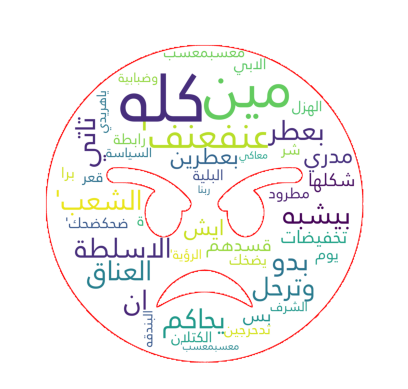

Vocab size = 25978
Mean = 19.650471504715046
Median = 17.0
Max = 792
Min = 3
Emoji count in corpus = 18250
{'😂': 2647, '😷': 1347, '😡': 1120, '👊': 937, '🔪': 715, '😤': 644, '🐸': 536, '💔': 531, '😣': 491, '🤢': 470, '👊🏻': 464, '💩': 439, '😠': 368, '👎': 293, '👎🏻': 292, '🤮': 266, '😭': 242, '😒': 199, '🤣': 165, '🙂': 160, '👊🏼': 147, '🐑': 133, '🌚': 132, '👞': 125, '🙉': 103, '😍': 99, '❤️': 97, '🐕': 88, '😅': 87, '🐒': 86, '🖕🏻': 84, '👎🏼': 79, '🐏': 77, '🙄': 76, '👌': 74, '🔥': 74, '😏': 73, '😢': 72, '🙈': 72, '😩': 72, '✋': 70, '🖕': 70, '😹': 68, '❤': 65, '🙊': 57, '👇': 55, '🐶': 53, '🏃': 53, '😕': 51, '😑': 51, '🤔': 51, '👊🏽': 51, '😁': 49, '💦': 47, '😉': 46, '😬': 45, '😎': 45, '👠': 45, '💪': 44, '🖕🏿': 43, '😔': 42, '😜': 42, '💙': 40, '😳': 40, '🦄': 40, '😊': 40, '☹️': 34, '😌': 34, '🐐': 33, '🙃': 32, '🤦🏻\u200d♀️': 32, '✌': 31, '😘': 31, '🤧': 30, '😆': 29, '😱': 29, '💛': 29, '👍': 29, '🐂': 28, '😞': 27, '👈': 26, '😪': 25, '💜': 25, '👎🏽': 25, '😐': 24, '🐄': 24, '🖕🏼': 24, '🌹': 24, '😖': 23, '😥': 23, '😫': 23, '👇🏻': 23, '🐴': 22, '👏': 2

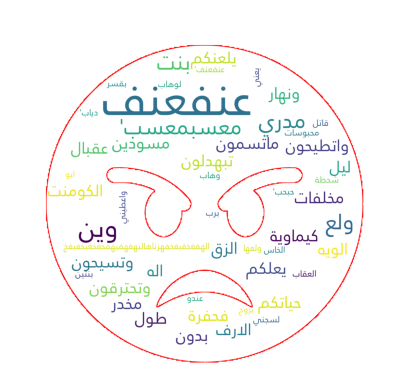

Vocab size = 18013
Mean = 20.733591564450183
Median = 17.0
Max = 6503
Min = 2
Emoji count in corpus = 9432
{'😂': 1308, '😷': 728, '😡': 535, '👊': 481, '🔪': 409, '😤': 385, '💔': 296, '😣': 292, '👊🏻': 263, '🤢': 260, '🐸': 240, '😠': 210, '👎': 160, '😭': 149, '👎🏻': 144, '💩': 120, '🤮': 101, '🤣': 92, '👊🏼': 89, '🙂': 81, '🌚': 72, '🐶': 67, '😒': 66, '🐑': 59, '🙉': 58, '👎🏼': 57, '🐒': 57, '👞': 50, '🤔': 46, '🖕': 42, '✋': 42, '🐏': 41, '🐕': 40, '🖕🏻': 39, '😏': 39, '👇': 39, '😍': 37, '😅': 37, '😎': 36, '😢': 31, '😧': 31, '👌': 29, '🙄': 29, '😑': 28, '🙈': 28, '😩': 28, '😹': 27, '❤️': 27, '🔥': 26, '😁': 25, '👏': 24, '🤦🏻\u200d♀️': 24, '🐄': 23, '😊': 22, '🙃': 22, '👊🏽': 21, '😬': 21, '❤': 21, '💜': 20, '👎🏿': 19, '😥': 19, '😳': 19, '😉': 19, '💚': 19, '💦': 18, '👠': 18, '🐴': 18, '🖕🏿': 18, '😔': 17, '🖕🏼': 17, '💙': 16, '💪': 16, '👍': 16, '🐐': 16, '🤧': 16, '💐': 16, '👀': 15, '☺': 15, '😕': 15, '☺️': 15, '🙊': 15, '🤦\u200d♀️': 15, '🏃': 15, '😌': 15, '👅': 14, '😐': 14, '☹️': 14, '😜': 14, '😝': 14, '✌': 13, '😪': 13, '😱': 13, '🐷': 12, '😈': 12,

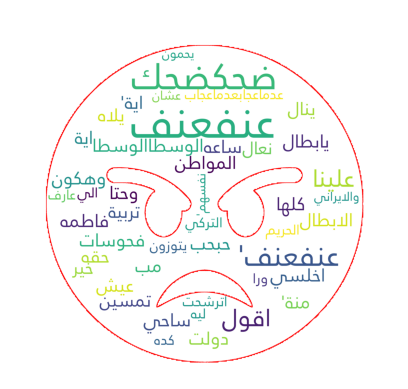

Vocab size = 16568
Mean = 19.66260162601626
Median = 17.0
Max = 225
Min = 3
Emoji count in corpus = 7524
{'😂': 1080, '😷': 639, '😡': 501, '👊': 344, '🔪': 284, '😤': 236, '🐸': 223, '💔': 206, '👊🏻': 203, '😣': 195, '🤢': 166, '👎': 159, '😠': 144, '👎🏻': 117, '🐕': 101, '😒': 97, '🤣': 86, '🤮': 81, '😭': 79, '💩': 69, '👊🏼': 68, '👞': 64, '🙂': 57, '🌚': 50, '🐑': 46, '😹': 43, '🤔': 42, '😩': 41, '😍': 38, '🐒': 38, '😅': 36, '❌': 36, '❤️': 34, '😏': 33, '✋': 30, '👎🏼': 30, '🙉': 29, '🙈': 28, '😢': 28, '😜': 28, '👠': 28, '👌': 28, '🙄': 28, '❤': 27, '🔥': 26, '😌': 26, '😁': 24, '🤦🏻\u200d♀️': 24, '👇': 23, '💜': 23, '😔': 22, '🖕': 22, '😳': 22, '🐶': 21, '🐐': 21, '😉': 20, '🦄': 20, '😊': 19, '💙': 19, '🏃': 19, '🖕🏻': 18, '💪': 18, '🖕🏿': 18, '🐏': 18, '🙃': 17, '😑': 16, '💦': 16, '👎🏽': 16, '😎': 16, '👊🏽': 16, '😞': 15, '🌹': 14, '🐷': 14, '😃': 14, '😖': 13, '😕': 13, '✌': 13, '👍': 11, '😆': 11, '🙊': 11, '🖕🏼': 11, '☹️': 11, '🚬': 10, '♥': 10, '🐴': 10, '😫': 10, '🐂': 10, '💘': 9, '😐': 9, '🤬': 9, '😘': 9, '😇': 9, '😈': 9, '🐃': 9, '😝': 9, '🦒': 9, '😱'

In [9]:
s1 = TextStatistics(cleaning_flag=True, show_vocab_counts=True, show_sequence_statistics=True, show_word_cloud_chart=True)
print(y_train['label'].value_counts())
s1.show_statistics(X_train)
print('')
print(y_test['label'].value_counts())
s1.show_statistics(X_test)
print('')
print(y_val['label'].value_counts())
s1.show_statistics(X_val)

0    14670
1     3862
Name: label, dtype: int64



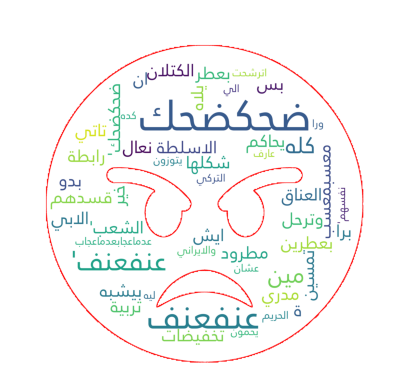

Vocab size = 34762
Mean = 19.936812000863373
Median = 17.0
Max = 6503
Min = 2
Emoji count in corpus = 35190
{'😂': 5019, '😷': 2714, '😡': 2156, '👊': 1762, '🔪': 1408, '😤': 1265, '💔': 1033, '🐸': 999, '😣': 978, '👊🏻': 930, '🤢': 896, '😠': 722, '💩': 628, '👎': 612, '👎🏻': 553, '😭': 470, '🤮': 448, '😒': 362, '🤣': 343, '👊🏼': 304, '🙂': 298, '🌚': 254, '👞': 239, '🐑': 238, '🐕': 229, '🙉': 190, '🐒': 181, '😍': 174, '👎🏼': 166, '😅': 160, '❤️': 158, '😏': 145, '✋': 142, '🐶': 141, '🖕🏻': 141, '😩': 141, '🤔': 139, '😹': 138, '🐏': 136, '🖕': 134, '🙄': 133, '👌': 131, '😢': 131, '🙈': 128, '🔥': 126, '👇': 117, '❤': 113, '😁': 98, '😎': 97, '😑': 95, '👠': 91, '👊🏽': 88, '🏃': 87, '😉': 85, '😜': 84, '🙊': 83, '😔': 81, '💦': 81, '😳': 81, '😊': 81, '🤦🏻\u200d♀️': 80, '😕': 79, '🖕🏿': 79, '💪': 78, '💙': 75, '😌': 75, '😬': 73, '🙃': 71, '🦄': 71, '🐐': 70, '💜': 68, '☹️': 59, '✌': 57, '👍': 56, '👏': 54, '🤧': 53, '❌': 52, '😆': 52, '🖕🏼': 52, '😞': 50, '😱': 50, '🐴': 50, '😥': 49, '🐄': 48, '😐': 47, '🐂': 47, '👎🏽': 47, '😖': 44, '😪': 44, '😘': 43, '💛': 42

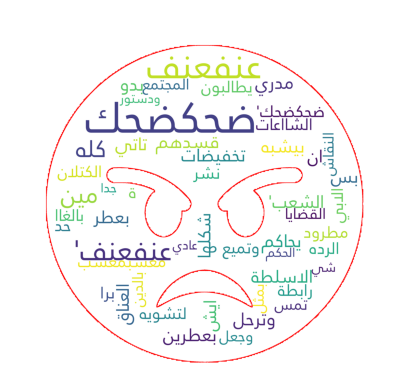

Vocab size = 29304
Mean = 18.706271301976823
Median = 16.0
Max = 792
Min = 2
Emoji count in corpus = 30234
{'😂': 4364, '😷': 2245, '😡': 1866, '👊': 1654, '🔪': 1288, '😤': 1126, '😣': 927, '💔': 904, '👊🏻': 847, '🐸': 811, '🤢': 803, '😠': 625, '💩': 549, '👎': 491, '👎🏻': 445, '😭': 419, '🤮': 385, '😒': 321, '👊🏼': 283, '🙂': 254, '🤣': 247, '🌚': 232, '🐕': 175, '🙉': 170, '😍': 159, '🐒': 154, '🐑': 149, '❤️': 149, '👞': 133, '🐶': 131, '✋': 130, '😅': 129, '😩': 125, '😢': 123, '😹': 122, '🙄': 120, '🖕🏻': 119, '😏': 116, '👎🏼': 115, '🙈': 113, '🤔': 105, '👌': 104, '🖕': 101, '🔥': 99, '❤': 96, '🐏': 96, '🏃': 83, '👠': 83, '😎': 82, '👊🏽': 82, '😑': 80, '😔': 76, '🙊': 76, '😁': 76, '👇': 76, '💪': 73, '😉': 72, '😳': 72, '😊': 72, '😌': 71, '🖕🏿': 71, '😕': 69, '😜': 69, '🦄': 69, '🤦🏻\u200d♀️': 66, '💜': 65, '😬': 64, '🙃': 64, '💙': 63, '💦': 63, '🐐': 54, '☹️': 52, '🤧': 49, '👏': 48, '😞': 45, '👍': 45, '😐': 44, '🐂': 44, '😱': 43, '😥': 43, '😆': 42, '😖': 41, '😧': 41, '✌': 41, '🌹': 39, '👎🏽': 39, '😘': 39, '😪': 38, '💚': 35, '☺️': 35, '😫': 34, '♥️'

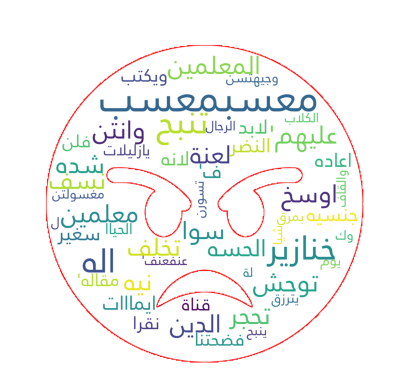

Vocab size = 19028
Mean = 24.611082340756084
Median = 20.0
Max = 6503
Min = 3
Emoji count in corpus = 4956
{'😂': 655, '😷': 469, '😡': 290, '🐸': 188, '😤': 139, '💔': 129, '👎': 121, '🔪': 120, '👎🏻': 108, '👊': 108, '👞': 106, '😠': 97, '🤣': 96, '🤢': 93, '🐑': 89, '👊🏻': 83, '💩': 79, '🤮': 63, '🐕': 54, '😭': 51, '😣': 51, '👎🏼': 51, '🙂': 44, '😒': 41, '👇': 41, '🐏': 40, '🤔': 34, '❌': 34, '🖕': 33, '😅': 31, ' 🏻': 31, '😏': 29, '👌': 27, '🐒': 27, '🔥': 27, '🌚': 22, '🐄': 22, '😁': 22, '🖕🏻': 22, '👊🏼': 21, '🙉': 20, '🖕🏼': 19, '👇🏻': 19, '🐴': 18, '💦': 18, '❤': 17, '😹': 16, '✌': 16, '🐐': 16, '😩': 16, '🙈': 15, '😑': 15, '😜': 15, '😍': 15, '😎': 15, '🤦🏻\u200d♀️': 14, '😉': 13, '🙄': 13, '🐷': 13, '🤦': 13, '💙': 12, '♂': 12, '✋': 12, '✋🏻': 12, '👍': 11, '😕': 10, '🐶': 10, ' 🏼': 10, '😲': 10, '😆': 10, '👎🏿': 10, '😼': 10, '💛': 9, '🤬': 9, '😳': 9, '😊': 9, '😬': 9, '🐮': 9, '❤️': 9, '‼️': 9, '🐖': 9, '🔴': 8, '👟': 8, '🙏': 8, '😀': 8, '👎🏽': 8, '🖕🏿': 8, '👋': 8, '😈': 8, '👠': 8, '😢': 8, '😱': 7, '🙃': 7, '🤪': 7, '☺': 7, '🙊': 7, '🤨': 7, '☹️': 7, 

In [10]:
X_train_stat = X_train.copy()
X_train_stat['label'] = y_train
X_train_normal = X_train_stat[X_train_stat['label']==0]
X_train_hate = X_train_stat[X_train_stat['label']==1]

X_test_stat = X_test.copy()
X_test_stat['label'] = y_test
X_test_normal = X_test_stat[X_test_stat['label']==0]
X_test_hate = X_test_stat[X_test_stat['label']==1]


X_val_stat = X_val.copy()
X_val_stat['label'] = y_val
X_val_normal = X_val_stat[X_val_stat['label']==0]
X_val_hate = X_val_stat[X_val_stat['label']==1]

ALL_DATA = X_train_stat.merge(X_test_stat,how='outer')
ALL_DATA = ALL_DATA.merge(X_val_stat,how='outer')

ALL_DATA_normal = ALL_DATA[ALL_DATA['label']==0]
ALL_DATA_hate = ALL_DATA[ALL_DATA['label']==1]

print(ALL_DATA['label'].value_counts())
print('')
s1.show_statistics(ALL_DATA)
print('')
s1.show_statistics(ALL_DATA_normal)
print('')
s1.show_statistics(ALL_DATA_hate)

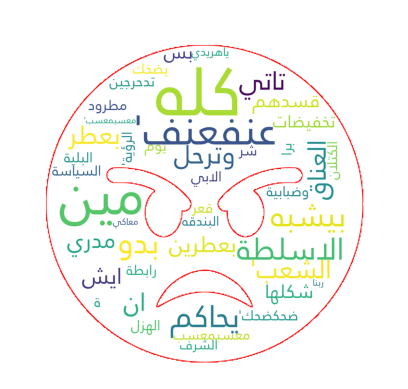

Vocab size = 21283
Mean = 18.724196058091287
Median = 16.0
Max = 792
Min = 3
Emoji count in corpus = 16105
{'😂': 2349, '😷': 1153, '😡': 1014, '👊': 907, '🔪': 674, '😤': 582, '💔': 484, '😣': 478, '🐸': 457, '👊🏻': 436, '🤢': 424, '💩': 402, '😠': 332, '🤮': 232, '👎🏻': 228, '👎': 228, '😭': 227, '😒': 174, '🙂': 143, '👊🏼': 136, '🌚': 126, '🤣': 119, '🙉': 96, '😍': 92, '❤️': 92, '🐑': 85, '🐒': 74, '🖕🏻': 72, '🐕': 71, '🙄': 71, '😢': 70, '👞': 70, '🙈': 65, '😩': 65, '😹': 65, '✋': 64, '😅': 62, '😏': 62, '🖕': 59, '👎🏼': 57, '🐏': 56, '👌': 55, '🙊': 54, '🔥': 54, '❤': 52, '🏃': 52, '🐶': 49, '👊🏽': 49, '😑': 45, '😕': 44, '👠': 43, '🤔': 43, '😬': 41, '💦': 41, '💪': 41, '😎': 41, '😉': 41, '🦄': 40, '😔': 39, '🖕🏿': 39, '😁': 38, '💙': 36, '😊': 36, '😜': 35, '😳': 32, '😌': 32, '☹️': 30, '🙃': 30, '🤧': 29, '🐂': 28, '👇': 28, '😘': 28, '😞': 27, '🤦🏻\u200d♀️': 27, '😱': 26, '😆': 25, '💜': 24, '💛': 24, '🐐': 24, '😐': 23, '🌹': 23, '😖': 22, '😥': 22, '😪': 22, '👈': 22, '👍': 22, '😫': 22, '🐄': 21, '👎🏽': 21, '👏': 20, '✌': 20, '😰': 19, '🤒': 19, '♥️': 17, '

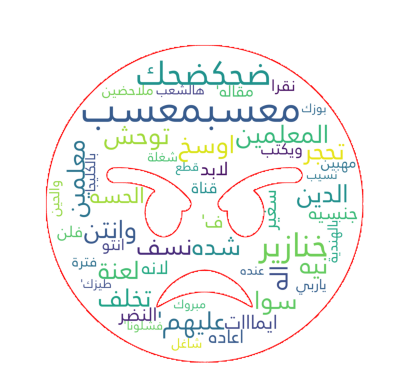

Vocab size = 12809
Mean = 23.145303326810176
Median = 20.0
Max = 88
Min = 3
Emoji count in corpus = 2145
{'😂': 298, '😷': 194, '😡': 106, '🐸': 79, '👎': 65, '👎🏻': 64, '😤': 62, '👞': 55, '🐑': 48, '💔': 47, '🤢': 46, '🤣': 46, '🔪': 41, '💩': 37, '😠': 36, '🤮': 34, '👊': 30, '👊🏻': 28, '👇': 27, '😒': 25, '😅': 25, '👎🏼': 22, '🐏': 21, '🔥': 20, '👌': 19, ' 🏻': 19, '🐕': 17, '🙂': 17, '😭': 15, '😣': 13, '❤': 13, '🐒': 12, '🖕🏻': 12, '👇🏻': 12, '😏': 11, '🖕': 11, '👊🏼': 11, '✌': 11, '😁': 11, '😼': 10, '🖕🏼': 9, '🐐': 9, '🤔': 8, '🤬': 8, '😳': 8, '🐴': 8, '😕': 7, '👍': 7, '🙈': 7, '♂': 7, '😜': 7, '🙉': 7, '😍': 7, '😩': 7, '🤦': 7, '🍌': 6, '😑': 6, '🌚': 6, '👡': 6, '✋': 6, '👋': 6, '💦': 6, '💛': 5, '🤤': 5, '🤦🏻\u200d♀️': 5, '😉': 5, ' 🏼': 5, '🙄': 5, '👟': 5, '🐮': 5, '❤️': 5, '💙': 4, '🐶': 4, '🔴': 4, '👈': 4, '🤯': 4, '😎': 4, '😊': 4, '💽': 4, '👎🏽': 4, '😆': 4, '🖕🏿': 4, '😬': 4, '☹️': 4, '😓': 4, '🔫': 3, '😔': 3, '😹': 3, '✋️': 3, '😱': 3, '🙏': 3, '🐄': 3, '😀': 3, '😘': 3, '🐷': 3, '💃🏻': 3, '🙊': 3, '✋🏻': 3, '🖤': 3, '💪': 3, '😪': 3, '👅': 3, '😃': 3, '🐖

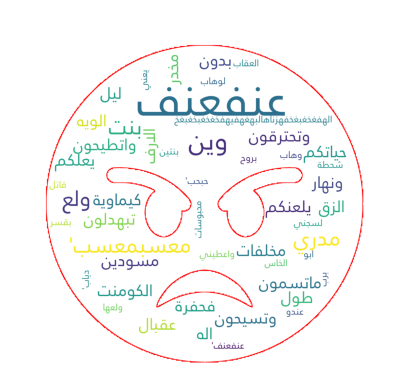

Vocab size = 13844
Mean = 18.58621628983928
Median = 16.0
Max = 135
Min = 2
Emoji count in corpus = 7572
{'😂': 1054, '😷': 553, '👊': 416, '😡': 403, '🔪': 353, '😤': 329, '😣': 265, '💔': 235, '🤢': 227, '👊🏻': 216, '🐸': 175, '😠': 169, '👎': 129, '👎🏻': 120, '😭': 117, '💩': 92, '👊🏼': 83, '🤮': 81, '🤣': 66, '🐶': 64, '🌚': 59, '🙂': 57, '😒': 56, '🙉': 50, '🐒': 45, '✋': 39, '🐑': 36, '👎🏼': 35, '🤔': 33, '😍': 32, '😅': 32, '😧': 31, '👇': 31, '🖕': 30, '🖕🏻': 30, '👞': 30, '😢': 28, '😎': 27, '🐕': 27, '🐏': 27, '🙈': 25, '❤️': 25, '🔥': 24, '😏': 24, '🙄': 24, '😩': 23, '😹': 22, '👌': 22, '🙃': 21, '👏': 21, '💜': 20, '❤': 20, '😑': 19, '😁': 19, '💚': 19, '😊': 18, '😳': 18, '🤦🏻\u200d♀️': 18, '😔': 17, '👊🏽': 17, '😉': 16, '😬': 16, '💐': 16, '🖕🏿': 16, '☺️': 15, '🐐': 15, '🤦\u200d♀️': 15, '🤧': 15, '😥': 15, '👅': 14, '💪': 14, '👠': 14, '👎🏿': 13, '😕': 13, '👍': 13, '😝': 13, '😌': 13, '😐': 12, '✌': 12, '☹️': 12, '🙊': 12, '🏃': 12, '♥️': 11, '✨': 11, '👀': 11, '💦': 11, '🖕🏼': 11, '💣': 11, '🐴': 11, '💋': 11, '💃': 11, '💙': 10, '☺': 10, '💕': 10, '💖

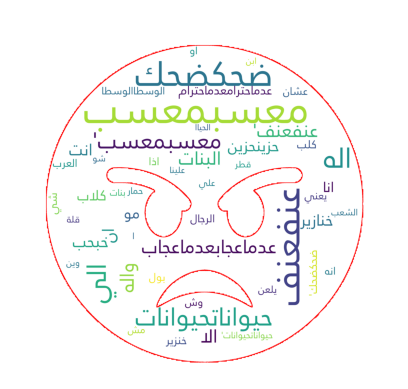

Vocab size = 8954
Mean = 28.81045081967213
Median = 19.5
Max = 6503
Min = 3
Emoji count in corpus = 1860
{'😂': 254, '😷': 175, '😡': 132, '👊': 65, '🐸': 65, '💔': 61, '😤': 56, '🔪': 56, '👊🏻': 47, '😠': 41, '🤢': 33, '😭': 32, '👎': 31, '💩': 28, '😣': 27, '🤣': 26, '👎🏻': 24, '🙂': 24, '🐑': 23, '👎🏼': 22, '👞': 20, '🤮': 20, '🐄': 19, '😏': 15, '🐏': 14, '🌚': 13, '🤔': 13, '🐕': 13, '🖕': 12, '🐒': 12, '😒': 10, '😎': 9, '🖕🏻': 9, '😑': 9, ' 🏻': 8, '👇': 8, '🙉': 8, '👌': 7, '🐴': 7, '✋🏻': 7, '💦': 7, '🤦🏻\u200d♀️': 6, '👎🏿': 6, '👊🏼': 6, '😁': 6, '😈': 6, '☠️': 6, '👇🏻': 6, '🖕🏼': 6, '💙': 6, '🙄': 5, '😬': 5, '😩': 5, '😍': 5, '😲': 5, '☺': 5, '‼️': 5, '✌🏼️': 5, '😹': 5, '😅': 5, '😜': 5, '😀': 5, '🐷': 4, '😥': 4, '🐮': 4, '🙏': 4, '👊🏽': 4, ' 🏼': 4, '🤦': 4, '♂': 4, '👀': 4, '🤪': 4, '👎🏽': 4, '😞': 4, '👠': 4, '😊': 4, '🔴': 3, '🐖': 3, '🤐': 3, '😪': 3, '👍': 3, '😱': 3, '✋': 3, '🙈': 3, '😆': 3, '🤨': 3, '👋🏻': 3, '👍🏻': 3, '🐶': 3, '💛': 3, '❌': 3, '👌🏻': 3, '🤗': 3, '😉': 3, '🙊': 3, '👏': 3, '😢': 3, '🏃': 3, '👧': 3, '👦': 3, '🌺': 3, '🍃': 3, '🥴': 3, '🤓': 2,

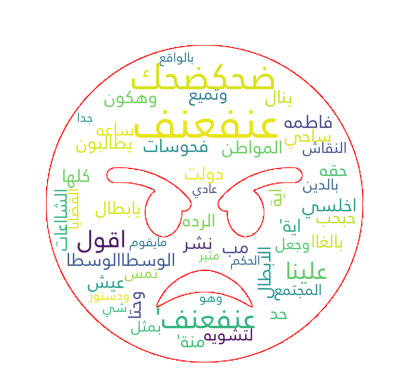

Vocab size = 13206
Mean = 18.722272317403064
Median = 16.0
Max = 225
Min = 3
Emoji count in corpus = 6557
{'😂': 961, '😷': 539, '😡': 449, '👊': 331, '🔪': 261, '😤': 215, '👊🏻': 195, '💔': 185, '😣': 184, '🐸': 179, '🤢': 152, '👎': 134, '😠': 124, '👎🏻': 97, '😒': 91, '🐕': 77, '😭': 75, '🤮': 72, '👊🏼': 64, '🤣': 62, '💩': 55, '🙂': 54, '🌚': 47, '😩': 37, '😅': 35, '😍': 35, '🐒': 35, '😹': 35, '👞': 33, '❤️': 32, '😏': 30, '🤔': 29, '🐑': 28, '✋': 27, '👌': 27, '😌': 26, '👠': 26, '🙄': 25, '😜': 25, '😢': 25, '🙉': 24, '❤': 24, '🙈': 23, '👎🏼': 23, '😳': 22, '🔥': 21, '🤦🏻\u200d♀️': 21, '💜': 21, '😔': 20, '🦄': 20, '😁': 19, '🏃': 19, '💪': 18, '😊': 18, '🐶': 18, '🖕🏻': 17, '👇': 17, '💙': 17, '😑': 16, '👎🏽': 16, '🖕🏿': 16, '👊🏽': 16, '😉': 15, '🐐': 15, '🌹': 14, '😎': 14, '😃': 14, '😞': 14, '🐏': 13, '🙃': 13, '😖': 12, '😕': 12, '🖕': 12, '💦': 11, '👍': 10, '🚬': 10, '🙊': 10, '☹️': 10, '💘': 9, '😐': 9, '🤬': 9, '😈': 9, '🐃': 9, '✌': 9, '🦒': 9, '🚶': 8, '😆': 8, '😘': 8, '🏃🏻\u200d♂️': 8, '😇': 8, '🐷': 8, '😝': 8, '😀': 8, '👧': 7, '😱': 7, '👌🏻': 7, '🤦\u2

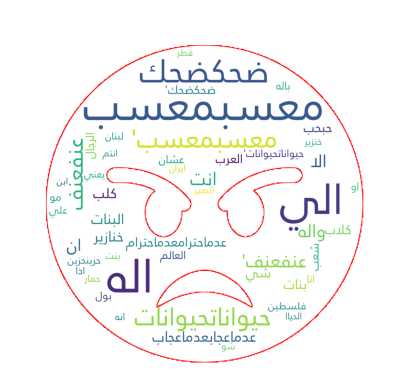

Vocab size = 7201
Mean = 23.321637426900583
Median = 20.0
Max = 94
Min = 3
Emoji count in corpus = 967
{'😂': 119, '😷': 100, '😡': 52, '🐸': 44, '👞': 31, '❌': 30, '👎': 25, '🐕': 24, '🤣': 24, '🔪': 23, '💔': 21, '😤': 21, '😠': 20, '👎🏻': 20, '🐑': 18, '💩': 14, '🤢': 14, '👊': 13, '🤔': 13, '😣': 11, '🖕': 10, '🤮': 9, '👊🏻': 8, '😹': 8, '👎🏼': 7, '🐷': 6, '👇': 6, '😒': 6, '🐐': 6, '😁': 5, '💦': 5, '🙈': 5, '🔥': 5, '🙉': 5, '😉': 5, '🐏': 5, '🙃': 4, '🖕🏼': 4, '😭': 4, ' 🏻': 4, '✌': 4, '😩': 4, '👊🏼': 4, '♥': 4, '☢': 3, '😢': 3, '🐒': 3, '😜': 3, '🤦🏻\u200d♀️': 3, '🏃\u200d♀️': 3, '😍': 3, '😏': 3, '❤': 3, '✋': 3, '🙂': 3, '👟': 3, '😲': 3, '🐂': 3, '😆': 3, '🐴': 3, '🤨': 3, '🙄': 3, '🐖': 3, '🌚': 3, '‼️': 3, '🐶': 3, '😫': 3, '🌶': 3, '👌🏾': 3, '👎🏾': 3, '👹': 2, '😔': 2, '🤦': 2, '↔': 2, '🏃🏻\u200d♀️': 2, '🧨': 2, '😎': 2, '💙': 2, '🤓': 2, '🤕': 2, '🛑': 2, '🖕🏿': 2, '🤭': 2, '♀': 2, '💜': 2, '👠': 2, '👎🏿': 2, '🤧': 2, '🎭': 2, '❤️': 2, '🤲🏽': 2, '✋🏻': 2, '☺️': 2, '🎪': 1, '😵': 1, '👂': 1, '👌🏻': 1, '🐝': 1, '😘': 1, '😇': 1, '🤍': 1, '💂\u200d♀️': 1, '♦': 1,

In [11]:
s1.show_statistics(X_train_normal)
print('')
s1.show_statistics(X_train_hate)
print('')

s1.show_statistics(X_test_normal)
print('')
s1.show_statistics(X_test_hate)
print('')

s1.show_statistics(X_val_normal)
print('')
s1.show_statistics(X_val_hate)
print('')